In [1]:
import numpy
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from google.colab import drive

In [2]:
torch.manual_seed(42)

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
path = '/content/drive/My Drive/Dataset/FMNIST/fashion-mnist_train.csv'
df = pd.read_csv(path)
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


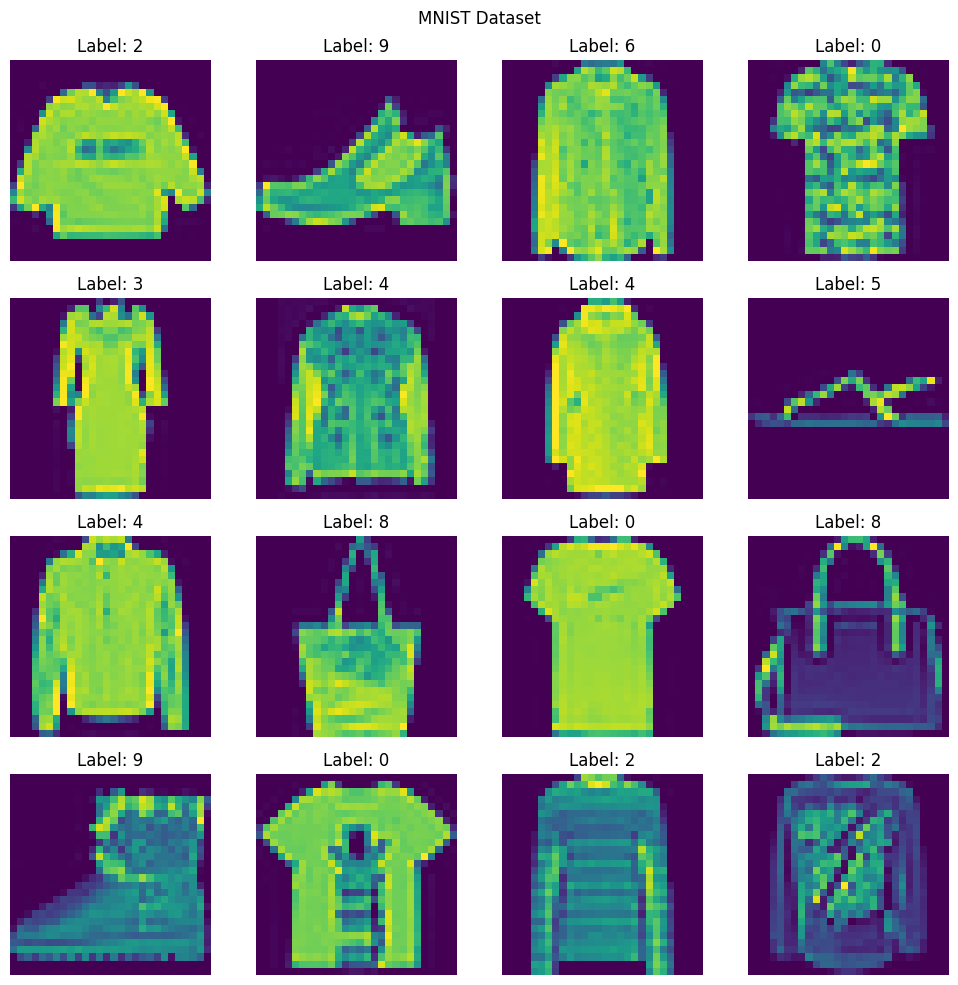

In [5]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("MNIST Dataset")

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i,0]}")
plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [6]:
X=df.iloc[:,1:]
Y=df.iloc[:,0]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [7]:
X_train/=255.0
X_test/=255.0

In [8]:
class Custom_Dataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [9]:
traindataset=Custom_Dataset(X_train.values,Y_train.values)
len(traindataset)

48000

In [10]:
testdataset=Custom_Dataset(X_test.values,Y_test.values)

In [11]:
class MyNN(nn.Module):
  def __init__(self,input_dim,out_dim,num_hidden_layers,n_layer,dropout_rate):
    super().__init__()
    layer=[]
    for i in range(num_hidden_layers):
      layer.append(nn.Linear(input_dim,n_layer))
      layer.append(nn.BatchNorm1d(n_layer))
      layer.append(nn.ReLU())
      layer.append(nn.Dropout(dropout_rate))
      input_dim=n_layer
    layer.append(nn.Linear(n_layer,out_dim))
    self.model=nn.Sequential(*layer)
  def forward(self,x):
    return self.model(x)

In [12]:
def objective(trial):
  num_hiddenLayers=trial.suggest_int("num_hiddenLayers",1,5)
  n_layer=trial.suggest_int("n_layer",0,128,step=1)
  epochs=trial.suggest_int("epochs",10,100,step=10)
  learnrate=trial.suggest_float("learnrate",1e-5,1e-1,log=True)
  lmd=trial.suggest_float("lmd",1e-5,1e-1,log=True)
  dropout_rate=trial.suggest_float("dropout_rate",0.1,0.5,step=0.1)
  batch_size=trial.suggest_int("batch_size",16,256,step=16)
  optimizer_name=trial.suggest_categorical("optimizer",["Adam","SGD","RMSprop"])

  train_loader=DataLoader(traindataset,batch_size=batch_size,shuffle=True,pin_memory=True)
  test_loader=DataLoader(testdataset,batch_size=batch_size,shuffle=False,pin_memory=True)


  input_dim=784
  out_dim=10

  model=MyNN(input_dim,out_dim,num_hiddenLayers,n_layer,dropout_rate)
  model=model.to(device)



  lossFN=nn.CrossEntropyLoss()
  if optimizer_name=="Adam":
    optimizer=optim.Adam(model.parameters(),lr=learnrate,weight_decay=lmd)
  elif optimizer_name=="RMSprop":
    optimizer=optim.RMSprop(model.parameters(),lr=learnrate,weight_decay=lmd)
  else:
    optimizer=optim.SGD(model.parameters(),lr=learnrate,weight_decay=lmd)


  #training loop
  for epoch in range(epochs):
   Cost=0
   for batch_features,batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)

    loss=lossFN(outputs,batch_labels)
    Cost+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  #EVALUATION
  model.eval()

  total=0
  correct=0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:
      batch_features=batch_features.to(device)
      batch_labels=batch_labels.to(device)
      outputs=model(batch_features)

    _,predicted =torch.max(outputs,1)

    total+= batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()

  accuracy=correct/total

  return accuracy

In [13]:
!pip install optuna
import optuna
study= optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.8 MB/s eta 0:00:00


[I 2025-10-04 17:13:19,192] A new study created in memory with name: no-name-a2392e45-f489-478b-8c24-f998cd9816ef
[I 2025-10-04 17:14:12,212] Trial 0 finished with value: 0.8854166666666666 and parameters: {'num_hiddenLayers': 2, 'n_layer': 118, 'epochs': 30, 'learnrate': 6.841501656750196e-05, 'lmd': 0.00016232118815856785, 'dropout_rate': 0.5, 'batch_size': 192, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8854166666666666.
[I 2025-10-04 17:14:28,566] Trial 1 finished with value: 0.5208333333333334 and parameters: {'num_hiddenLayers': 2, 'n_layer': 69, 'epochs': 10, 'learnrate': 4.5742963603724506e-05, 'lmd': 0.004296807395197003, 'dropout_rate': 0.30000000000000004, 'batch_size': 144, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8854166666666666.
[I 2025-10-04 17:15:31,404] Trial 2 finished with value: 0.8854166666666666 and parameters: {'num_hiddenLayers': 2, 'n_layer': 59, 'epochs': 30, 'learnrate': 0.00022375158245022025, 'lmd': 0.0030325273772219977, 'dropout_rate':

In [14]:
study.best_value
study.best_params

{'num_hiddenLayers': 2,
 'n_layer': 118,
 'epochs': 30,
 'learnrate': 6.841501656750196e-05,
 'lmd': 0.00016232118815856785,
 'dropout_rate': 0.5,
 'batch_size': 192,
 'optimizer': 'Adam'}

In [15]:
# Define and train the model with the best parameters
input_dim = 784
out_dim = 10
best_params = study.best_params
model = MyNN(input_dim, out_dim, best_params['num_hiddenLayers'], best_params['n_layer'], best_params['dropout_rate'])
model = model.to(device)

lossFN = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
learnrate = best_params['learnrate']
lmd = best_params['lmd']

if optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learnrate, weight_decay=lmd)
elif optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=learnrate, weight_decay=lmd)
else:
    optimizer = optim.SGD(model.parameters(), lr=learnrate, weight_decay=lmd)

epochs = best_params['epochs']
batch_size = best_params['batch_size']

train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(testdataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Training loop
for epoch in range(epochs):
    Cost = 0
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_features)

        loss = lossFN(outputs, batch_labels)
        Cost += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation on test set
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {correct/total}")

Test Accuracy: 0.8700833333333333


In [16]:
# Evaluation on train set
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Train Accuracy: {correct/total}")

Train Accuracy: 0.8888958333333333


**Hyperparameters**
1. Number of hidden layers

2. Neurons per layer

3. Number of epochs

4. Optimizer

5. Learning rate

6. Batch size

7. Dropout rate

8. Weight decay(λ)

In [17]:
# Visualize optimization history
optuna.visualization.plot_optimization_history(study)

In [18]:
# Visualize parameter importances
optuna.visualization.plot_param_importances(study)